# Installs and imports

In [ ]:
!pip install torch_geometric

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle as pkl

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch_geometric.data import Dataset, DataLoader, Data
from torch_geometric.nn import GraphConv
from torch_geometric.utils import to_undirected

# Utils

### Plotting

In [3]:
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

def plot_hexbin(targ, pred, title="", scale="linear",
                inc_factor = 1.1, dec_factor = 0.9,
                bins=None, plot_helper_lines=False,
                cmap='viridis',lims=None):

    fig, ax = plt.subplots(figsize=(6,6))

    mae = mean_absolute_error(targ, pred)
    r, _ = pearsonr(targ, pred)

    if scale == 'log':
        pred = np.abs(pred) + 1e-8
        targ = np.abs(targ) + 1e-8

    lim_min = min(np.min(pred), np.min(targ))
    if lim_min < 0:
        if lim_min > -0.1:
            lim_min = -0.1
        lim_min *= inc_factor
    else:
        if lim_min < 0.1:
            lim_min = -0.1
        lim_min *= dec_factor
    lim_max = max(np.max(pred), np.max(targ))
    if lim_max <= 0:
        if lim_max > -0.1:
            lim_max = 0.2
        lim_max *= dec_factor
    else:
        if lim_max < 0.1:
            lim_max = 0.25
        lim_max *= inc_factor

    if lims:
        lim_min = lims[0]
        lim_max = lims[1]

#     ax.set_xlim(0.8, 1.05)
#     ax.set_ylim(0.8, 1.05)
    ax.set_aspect('equal')

    #ax.plot((lim_min, lim_max),
    #        (lim_min, lim_max),
    #        color='#000000',
    #        zorder=-1,
    #        linewidth=0.5)
    ax.axline((0, 0), (1, 1),
           color='#000000',
           zorder=-1,
           linewidth=0.5)

    hb = ax.hexbin(
        targ, pred,
        cmap=cmap,
        gridsize=60,
        bins=bins,
        mincnt=1,
        edgecolors=None,
        linewidths=(0.1,),
        xscale=scale,
        yscale=scale,
        extent=(lim_min, lim_max, lim_min, lim_max))


    cb = fig.colorbar(hb, shrink=0.822)
    cb.set_label('Count')

    if plot_helper_lines:

        if scale == 'linear':
            x = np.linspace(lim_min, lim_max, 50)
            y_up = x + mae
            y_down = x - mae

        elif scale == 'log':
            x = np.logspace(np.log10(lim_min), np.log10(lim_max), 50)

            # one order of magnitude
            y_up = np.maximum(x + 1e-2, x * 10)
            y_down = np.minimum(np.maximum(1e-8, x - 1e-2), x / 10)

            # one kcal/mol/Angs
            y_up = x + 1
            y_down = np.maximum(1e-8, x - 1)


        for y in [y_up, y_down]:
            ax.plot(x,
                    y,
                    color='#000000',
                    zorder=2,
                    linewidth=0.5,
                    linestyle='--')

    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Predicted order parameters', fontsize=12)
    ax.set_xlabel('Experimental order parameters', fontsize=12)

    ax.annotate("Pearson's r: %.3f \nMAE: %.3f" % (r, mae),
                (0.03, 0.88),
                xycoords='axes fraction',
                fontsize=12)

    return r, mae, ax, hb

# Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
pdb_graphs = pkl.load(open('/content/drive/MyDrive/2022-2023/CS 229/Final Project/Code/pdb_graphs.pkl', 'rb'))

In [7]:
err_ids = []
for i,entry in pdb_graphs.items():
  if len(entry[0]) != len(entry[3]):
    err_ids.append(i)

In [8]:
print(len(pdb_graphs))
pdb_graphs = {k:v for k,v in pdb_graphs.items() if k not in err_ids}
print(len(pdb_graphs))

940
924


In [9]:
node_features = [entry[0] for entry in pdb_graphs.values()]
coords = [entry[1] for entry in pdb_graphs.values()]
edge_indices = [entry[2] for entry in pdb_graphs.values()]

In [10]:
labels = [entry[3] for entry in pdb_graphs.values()]
labels = [torch.min(l,torch.tensor([1.1])) for l in labels]
labels = [torch.max(l,torch.tensor([-1])) for l in labels]

In [11]:
(node_train, node_test, \
 coord_train, coord_test, \
 edge_train, edge_test, \
 y_train, y_test) = train_test_split(
                                      node_features,
                                      coords,
                                      edge_indices,
                                      labels,
                                      test_size = 0.2,
                                      random_state = 0
                                      )

In [12]:
# Scaler for node features that are not one-hots
scaler = ColumnTransformer(
     [("scaler", StandardScaler(), slice(20, 34))],
     remainder='passthrough')
# Fit scaler to training data
scaler.fit(torch.concatenate(node_train))
# Apply scalar to all splits
node_train = [scaler.transform(entry) for entry in node_train]
node_test = [scaler.transform(entry) for entry in node_test]

# Models

## Random Forest, Depth Analysis

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [14]:
rf_x_train = np.concatenate(node_train)
rf_x_test = np.concatenate(node_test)

rf_y_train = np.concatenate(y_train)
rf_y_test = np.concatenate(y_test)

In [15]:
train_r = []
train_mae = []
test_r = []
test_mae = []
depths = [5,10,15,20,25,30]
for depth in tqdm(depths):
  rf = RandomForestRegressor(random_state=0, max_depth=depth)
  rf.fit(rf_x_train, rf_y_train)
  rf_train_preds = rf.predict(rf_x_train)
  rf_test_preds = rf.predict(rf_x_test)
  train_r.append(pearsonr(rf_train_preds, rf_y_train)[0])
  train_mae.append(mean_absolute_error(rf_train_preds, rf_y_train))
  test_r.append(pearsonr(rf_test_preds, rf_y_test)[0])
  test_mae.append(mean_absolute_error(rf_test_preds, rf_y_test))

100%|██████████| 6/6 [08:27<00:00, 84.64s/it]


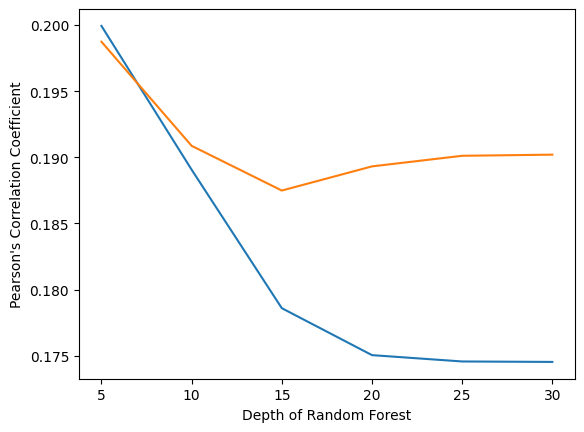

In [16]:
plt.plot(depths, train_mae)
plt.plot(depths, test_mae)
plt.xlabel("Depth of Random Forest")
plt.ylabel("Pearson's Correlation Coefficient")
plt.show()

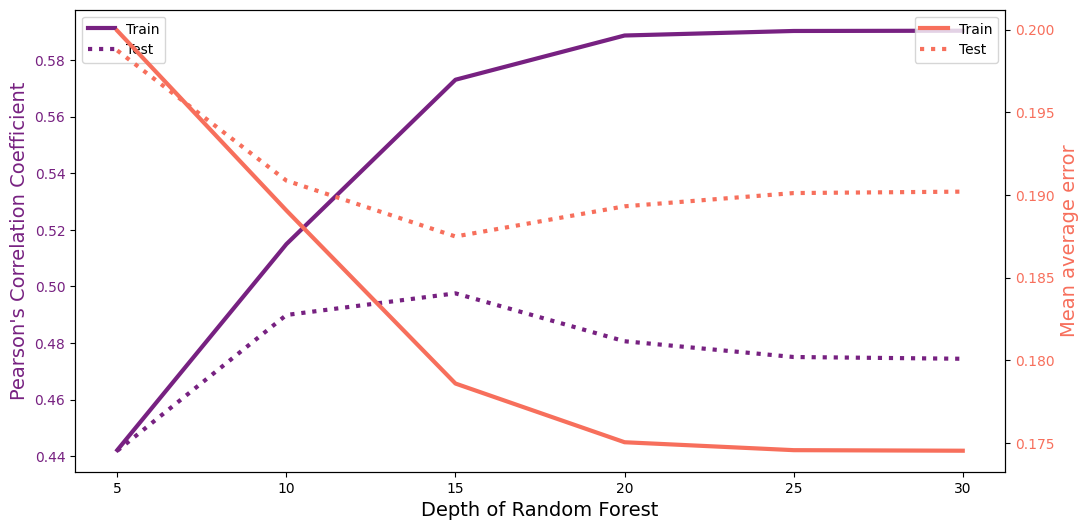

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
purple = "#772181"
orange = "#f76f5c"
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(depths, train_r, color=purple, lw=3, label="Train")
ax1.plot(depths, test_r, color=purple, lw=3, label="Test", linestyle="dotted")
ax2.plot(depths, train_mae, color=orange, lw=3, label="Train")
ax2.plot(depths, test_mae, color=orange, lw=3, label="Test", linestyle="dotted")
ax1.set_xlabel("Depth of Random Forest", fontsize=14)
ax1.set_ylabel("Pearson's Correlation Coefficient", color=purple, fontsize=14)
ax1.tick_params(axis="y", labelcolor=purple)
ax2.set_ylabel("Mean average error", color=orange, fontsize=14)
ax2.tick_params(axis="y", labelcolor=orange)
ax1.legend()
ax2.legend()
plt.show()
fig.savefig("rf_depth.png")

from google.colab import files
files.download("rf_depth.png")

## Random Forest, Input Feature Analysis

In [ ]:
node_train_oh = np.concatenate([node_train[i][:,14:-8] for i in range(len(node_train))])
node_train_oh_rsa_ss = np.concatenate([node_train[i][:,13:] for i in range(len(node_train))])
node_train_oh_rsa = np.concatenate([node_train[i][:,13:-8] for i in range(len(node_train))])
node_train_oh_ss = np.concatenate([node_train[i][:,14:] for i in range(len(node_train))])
node_train_no_structural = np.concatenate([np.concatenate([node_train[i][:,:13],
                                                           node_train[i][:,14:-8]],axis=1) for i in range(len(node_train))])

In [ ]:
node_test_oh = np.concatenate([node_test[i][:,14:-8] for i in range(len(node_test))])
node_test_oh_rsa_ss = np.concatenate([node_test[i][:,13:] for i in range(len(node_test))])
node_test_oh_rsa = np.concatenate([node_test[i][:,13:-8] for i in range(len(node_test))])
node_test_oh_ss = np.concatenate([node_test[i][:,14:] for i in range(len(node_test))])
node_test_no_structural = np.concatenate([np.concatenate([node_test[i][:,:13],
                                                          node_test[i][:,14:-8]],axis=1) for i in range(len(node_test))])

In [ ]:
train_Xs = [node_train_oh, node_train_oh_rsa_ss, node_train_oh_rsa, node_train_oh_ss, node_train_no_structural]
test_Xs = [node_test_oh, node_test_oh_rsa_ss, node_test_oh_rsa, node_test_oh_ss, node_test_no_structural]

[0.2227795637055761,
 0.54764707461155,
 0.4783171150115747,
 0.27405738465537843,
 0.2228081438716483]

In [ ]:
train_r = []
train_mae = []
test_r = []
test_mae = []

for X_train, X_test in tqdm(zip(train_Xs, test_Xs), total=len(train_Xs)):
  rf = RandomForestRegressor(random_state=0, max_depth=15)
  rf.fit(X_train, rf_y_train)
  rf_train_preds = rf.predict(X_train)
  rf_test_preds = rf.predict(X_test)
  train_r.append(pearsonr(rf_train_preds, rf_y_train)[0])
  train_mae.append(mean_absolute_error(rf_train_preds, rf_y_train))
  test_r.append(pearsonr(rf_test_preds, rf_y_test)[0])
  test_mae.append(mean_absolute_error(rf_test_preds, rf_y_test))

100%|██████████| 5/5 [02:24<00:00, 28.82s/it]


In [ ]:
rf = RandomForestRegressor(random_state=0, max_depth=15)
rf.fit(rf_x_train, rf_y_train)
rf_train_preds = rf.predict(rf_x_train)
rf_test_preds = rf.predict(rf_x_test)
train_r.append(pearsonr(rf_train_preds, rf_y_train)[0])
train_mae.append(mean_absolute_error(rf_train_preds, rf_y_train))
test_r.append(pearsonr(rf_test_preds, rf_y_test)[0])
test_mae.append(mean_absolute_error(rf_test_preds, rf_y_test))

In [ ]:
train_Xs = [node_train_oh, node_train_oh_rsa_ss, node_train_oh_rsa, node_train_oh_ss, node_train_no_structural]
test_Xs = [node_test_oh, node_test_oh_rsa_ss, node_test_oh_rsa, node_test_oh_ss, node_test_no_structural]

In [ ]:
print(test_r)
print(test_mae)

[0.2164244505143879, 0.4976410486854568, 0.45452443943857074, 0.26814079337046787, 0.2165189524212092, 0.49752522027623514]
[0.2169883525350645, 0.1883281863335036, 0.196789125667399, 0.21338913701254125, 0.21698362691194623, 0.1874900646358246]


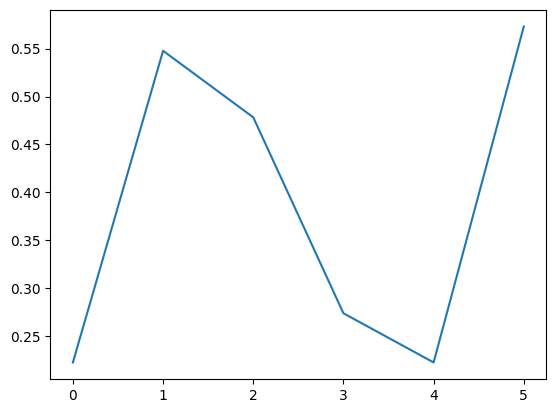

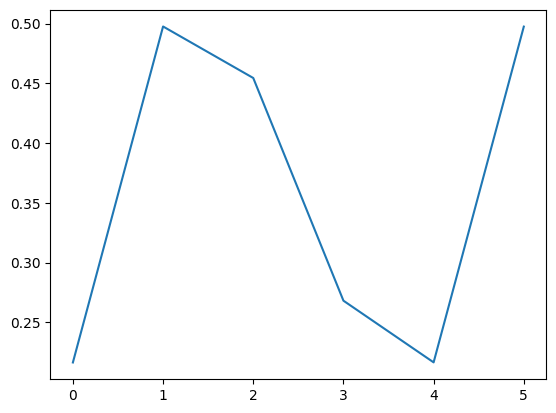

In [ ]:
plt.plot(test_r)

## GCN, Input Feature Analysis

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, MSELoss
from torch_geometric.nn import GCNConv, TransformerConv, ResGatedGraphConv

class GraphTransformerGCN(torch.nn.Module):
    def __init__(self,
                 num_input_features,
                 hidden_dim,
                 seed=0
                 ):
        super().__init__()
        torch.manual_seed(seed)
        self.conv1 = GCNConv(num_input_features, hidden_dim)
        self.transformer_conv = TransformerConv(hidden_dim,hidden_dim)
        self.res_gated_conv = ResGatedGraphConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.out = Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.transformer_conv(x, edge_index)
        x = self.res_gated_conv(x, edge_index)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.out(x)

        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def train(model, optimizer, criterion, loader):
  model.train()

  for data in loader:
      data = data.to(device)
      optimizer.zero_grad()  # Clear gradients.
      out = torch.squeeze(model(data))  # Perform a forward pass
      loss = criterion(out, data.y)
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.

  return loss.detach().cpu()

@torch.no_grad()
def test(model, loader):
    model.eval()

    labels = []
    preds = []
    for data in loader:
        data = data.to(device)
        out = model(data)
        labels.append(data.y.cpu())
        preds.append(out.cpu())
    return (labels, preds)

In [ ]:
class ProteinDataset(Dataset):
    def __init__(self, node_features, edge_indices, labels):
        self.node_features = node_features
        self.edge_indices = edge_indices
        self.labels = labels
        super(ProteinDataset, self).__init__()

    def len(self):
        return len(self.node_features)

    def get(self, index):
        x = torch.tensor(self.node_features[index]).to(torch.float32)   # Node features tensor for the protein graph
        edge_index = to_undirected(self.edge_indices[index])   # Edge indices tensor for the protein graph
        y = self.labels[index]  # Label tensor for the nodes in the protein graph

        data = Data(x=x, edge_index=edge_index, y=y)

        return data

In [ ]:
input_dim = 42
hidden_dim = 32
lr = 0.01

In [ ]:
def train_test_gcn(node_train, node_test):

  train_dataset = ProteinDataset(node_train, edge_train, y_train)
  test_dataset = ProteinDataset(node_test, edge_test, y_test)

  batch_size = 32
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  input_dim = train_dataset[0].x.shape[1]
  model = GraphTransformerGCN(input_dim,hidden_dim).to(device)
  optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(
                        optimizer,
                        milestones=[25,50,75],
                        gamma=0.1)
  criterion = MSELoss()

  losses = []
  for epoch in range(100):
      loss = train(model, optimizer, criterion, train_loader)
      losses.append(loss)
      scheduler.step()

  gcn_train_labels, gcn_train_preds = test(model, train_loader)
  gcn_test_labels, gcn_test_preds = test(model, test_loader)

  gcn_train_labels = torch.concatenate(gcn_train_labels).tolist()
  gcn_train_preds = torch.squeeze(torch.concatenate(gcn_train_preds)).tolist()
  gcn_test_labels = torch.concatenate(gcn_test_labels).tolist()
  gcn_test_preds = torch.squeeze(torch.concatenate(gcn_test_preds)).tolist()

  return (pearsonr(gcn_train_labels, gcn_train_preds)[0], mean_absolute_error(gcn_train_labels, gcn_train_preds),
          pearsonr(gcn_test_labels, gcn_test_preds)[0], mean_absolute_error(gcn_test_labels, gcn_test_preds))

In [ ]:
node_train_oh = [node_train[i][:,14:-8] for i in range(len(node_train))]
node_train_oh_rsa_ss = [node_train[i][:,13:] for i in range(len(node_train))]
node_train_oh_rsa = [node_train[i][:,13:-8] for i in range(len(node_train))]
node_train_oh_ss = [node_train[i][:,14:] for i in range(len(node_train))]
node_train_no_structural = [np.concatenate([node_train[i][:,:13],
                            node_train[i][:,14:-8]],axis=1) for i in range(len(node_train))]

In [ ]:
node_test_oh = [node_test[i][:,14:-8] for i in range(len(node_test))]
node_test_oh_rsa_ss = [node_test[i][:,13:] for i in range(len(node_test))]
node_test_oh_rsa = [node_test[i][:,13:-8] for i in range(len(node_test))]
node_test_oh_ss = [node_test[i][:,14:] for i in range(len(node_test))]
node_test_no_structural = [np.concatenate([node_test[i][:,:13],
                           node_test[i][:,14:-8]],axis=1) for i in range(len(node_test))]

In [ ]:
train_Xs = [node_train_oh, node_train_oh_rsa_ss, node_train_oh_rsa, node_train_oh_ss, node_train_no_structural, node_train]
test_Xs = [node_test_oh, node_test_oh_rsa_ss, node_test_oh_rsa, node_test_oh_ss, node_test_no_structural, node_train]

In [ ]:
train_r = []
train_mae = []
test_r = []
test_mae = []

for X_train, X_test in tqdm(zip(train_Xs, test_Xs), total=len(train_Xs)):
  outputs = train_test_gcn(X_train, X_test)
  train_r.append(outputs[0])
  train_mae.append(outputs[1])
  test_r.append(outputs[2])
  test_mae.append(outputs[3])

 17%|█▋        | 1/6 [01:05<05:26, 65.22s/it]/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
 33%|███▎      | 2/6 [02:10<04:20, 65.16s/it]/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
 50%|█████     | 3/6 [03:16<03:16, 65.51s/it]/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
 67%|██████▋   | 4/6 [04:23<02:12, 66.24s/it]/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
 83%|████████▎ | 5/6 [05:29<01:06, 66.12s/it]/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: User

IndexError: ignored

In [ ]:
train_Xs = [node_train_oh, node_train_oh_rsa_ss, node_train_oh_rsa, node_train_oh_ss, node_train_no_structural, node_train]
test_Xs = [node_test_oh, node_test_oh_rsa_ss, node_test_oh_rsa, node_test_oh_ss, node_test_no_structural, node_train]

In [ ]:
print(test_r)

[0.5179231340872608, 0.5871260102271567, 0.5591139291788103, 0.5471058805318105, 0.544087662341084]


In [ ]:
print(test_mae)

[0.18888032671878185, 0.1768633335800198, 0.18249562625864668, 0.1835864585940854, 0.18403361599675136]


In [ ]:
outputs = train_test_gcn(node_train, node_test)
train_r.append(outputs[0])
train_mae.append(outputs[1])
test_r.append(outputs[2])
test_mae.append(outputs[3])

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
print(test_r)
print(test_mae)

[0.5179231340872608, 0.5871260102271567, 0.5591139291788103, 0.5471058805318105, 0.544087662341084, 0.61410608515031]


In [ ]:
print(test_mae)

[0.18888032671878185, 0.1768633335800198, 0.18249562625864668, 0.1835864585940854, 0.18403361599675136, 0.17145000199149749]
